In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-05-17 07:02:07--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-05-17 07:02:07 (2.65 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



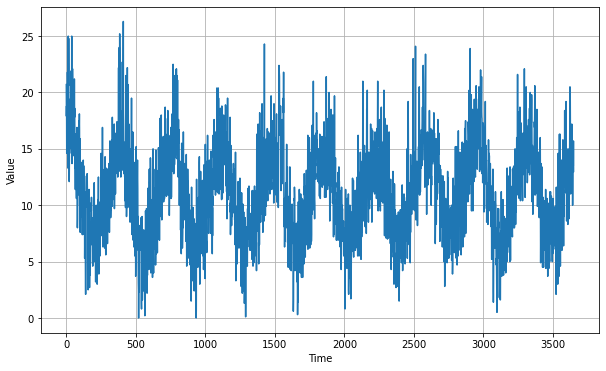

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  lines = csv.reader(csvfile, delimiter=',')
  next(lines)
  idx = 0
  for line in lines:
    temp = float(line[1])
    time_step.append(idx)
    temps.append(temp)
    idx = idx + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [20]:
print(idx)

3650


In [0]:
split_time = 2500
time_train = time_step[:split_time]
x_train = series[:split_time]
time_valid = time_step[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [21]:
x_valid

array([11. , 12.6, 14.7, ..., 13.5, 15.7, 13. ])

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda x: (x[:-1], x[-1]))
    return dataset.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 32
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
tf.keras.layers.LSTM(32, return_sequences=True),
tf.keras.layers.LSTM(16),
tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 28ms/step - loss: 10.6840 - mae: 11.1836 - lr: 1.0000e-05
Epoch 2/100
10/10 [==============================] - 0s 38ms/step - loss: 10.6719 - mae: 11.1716 - lr: 1.1220e-05
Epoch 3/100
10/10 [==============================] - 0s 36ms/step - loss: 10.6544 - mae: 11.1541 - lr: 1.2589e-05
Epoch 4/100
10/10 [==============================] - 0s 39ms/step - loss: 10.6347 - mae: 11.1344 - lr: 1.4125e-05
Epoch 5/100
10/10 [==============================] - 0s 36ms/step - loss: 10.6135 - mae: 11.1131 - lr: 1.5849e-05
Epoch 6/100
10/10 [==============================] - 0s 36ms/step - loss: 10.5913 - mae: 11.0909 - lr: 1.7783e-05
Epoch 7/100
10/10 [==============================] - 0s 39ms/step - loss: 10.5703 - mae: 11.0699 - lr: 1.9953e-05
Epoch 8/100
10/10 [==============================] - 0s 38ms/step - loss: 10.5497 - mae: 11.0492 - lr: 2.2

(1e-05, 1.0, 0.0, 10.0)

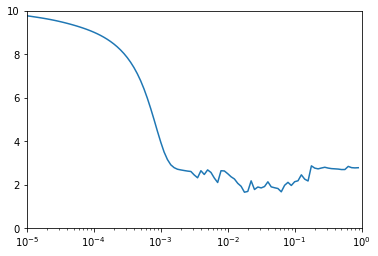

In [28]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 10])

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
tf.keras.layers.LSTM(32, return_sequences=True),
tf.keras.layers.LSTM(16),
tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/200
10/10 [==============================] - 0s 26ms/step - loss: 8.7227 - mae: 9.2206
Epoch 2/200
10/10 [==============================] - 0s 37ms/step - loss: 5.1032 - mae: 5.5867
Epoch 3/200
10/10 [==============================] - 0s 44ms/step - loss: 2.9052 - mae: 3.3732
Epoch 4/200
10/10 [==============================] - 0s 40ms/step - loss: 2.9686 - mae: 3.4399
Epoch 5/200
10/10 [==============================] - 0s 40ms/step - loss: 2.7300 - mae: 3.1952
Epoch 6/200
10/10 [==============================] - 0s 41ms/step - loss: 2.7383 - mae: 3.2033
Epoch 7/200
10/10 [==============================] - 0s 45ms/step - loss: 2.6895 - mae: 3.1556
Epoch 8/200
10/10 [==============================] - 0s 41ms/step - loss: 2.6495 - mae: 3.1150
Epoch 9/200
10/10 [==============================] - 0s 44ms/step - loss: 2.5811 - mae: 3.0451
Epoch 10/200
10/10 [==============================] - 0s 38ms/step - loss: 2.5218 - mae: 2.9864
Epoch 11/200
10/10 [=============================

In [0]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:, -1] 
#no need for 3rd index as sequences not returned from LSTM

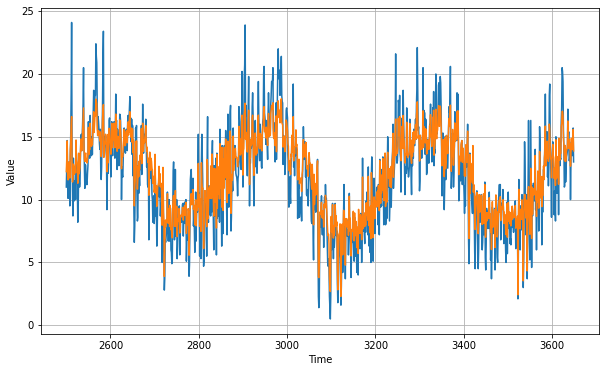

In [34]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [35]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.1074984

In [36]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.229156 13.190522 14.674666 ... 14.077725 15.581593 13.880238]
